In [30]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
import os
import sys
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

notebook_dir = os.path.dirname(os.path.abspath(''))
src_path = os.path.join(notebook_dir, '..\src')
sys.path.append(src_path)
print(src_path)

d:\ANNACONDA\projects\interest_rate_prediction\notebooks\..\src


In [31]:
pd.set_option("display.max_columns", 200)

In [32]:
from config import MODEL_DATA_PATH

In [33]:
df = pd.read_parquet(f"../{MODEL_DATA_PATH}")
df

,Year,Month,Day,Quarter,4 WEEKS BANK DISCOUNT,4 WEEKS COUPON EQUIVALENT,8 WEEKS BANK DISCOUNT,8 WEEKS COUPON EQUIVALENT,13 WEEKS BANK DISCOUNT,13 WEEKS COUPON EQUIVALENT,17 WEEKS BANK DISCOUNT,17 WEEKS COUPON EQUIVALENT,26 WEEKS BANK DISCOUNT,26 WEEKS COUPON EQUIVALENT,LT COMPOSITE (>10 Yrs),TREASURY 20-Yr CMT,20 YR,30 YR,LT Real Average (10> Yrs),1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,Close/Last_nsdq,Volume,Open_dow,High_dow,Low_dow,Crude_Oil_Price,CPI,Day_fed_funds,Equipment,Intellectual property products,Structures,Durable goods,Goods,Gross domestic product,National defense,Nondefense,Nondurable goods,Nonresidential,Residential,Services,Exports,Federal,Fixed investment,Goods_2,"Gross domestic product, current dollars",Imports,Services_2,State and local,Addendum:,Government consumption expenditures and gross investment,Gross private domestic investment,Personal consumption expenditures,Home Sales,Home_Sales,Total,1 unit,Open_sp500,High_sp500,Low_sp500,PPI,Category,All other gen. merchandise stores,All other home furnishings stores,Automobile and other motor vehicle dealers,Automobile dealers,"Automotive parts, acc., and tire stores","Beer, wine and liquor stores","Beer, wine, and liquor stores",Book stores,Building mat. and garden equip. and supplies dealers,Building mat. and supplies dealers,Clothing and clothing access. stores,Clothing stores,Department stores,Department stores(excl. discount department stores),Discount dept. stores,Drinking places,Electronic shopping and mail order houses,Electronic shopping and mail-order houses,Electronics and appliance stores,Electronics stores,Family clothing stores,Floor covering stores,Food and beverage stores,Food services and drinking places,Fuel dealers,Full service restaurants,Furniture and home furnishings stores,Furniture stores,...,"Close_sp500_1_4,378.41","Close_sp500_1_4,381.89","Close_sp500_1_4,382.78","Close_sp500_1_4,387.55","Close_sp500_1_4,388.71","Close_sp500_1_4,396.44","Close_sp500_1_4,398.95","Close_sp500_1_4,399.77","Close_sp500_1_4,402.20","Close_sp500_1_4,404.33","Close_sp500_1_4,405.71","Close_sp500_1_4,409.53","Close_sp500_1_4,409.59","Close_sp500_1_4,411.55","Close_sp500_1_4,411.59","Close_sp500_1_4,415.24","Close_sp500_1_4,425.84","Close_sp500_1_4,433.31","Close_sp500_1_4,436.01","Close_sp500_1_4,437.86","Close_sp500_1_4,439.26","Close_sp500_1_4,443.95","Close_sp500_1_4,446.82","Close_sp500_1_4,450.32","Close_sp500_1_4,450.38","Close_sp500_1_4,451.14","Close_sp500_1_4,453.53","Close_sp500_1_4,455.59","Close_sp500_1_4,457.49","Close_sp500_1_4,461.90","Close_sp500_1_4,464.05","Close_sp500_1_4,465.48","Close_sp500_1_4,467.44","Close_sp500_1_4,467.71","Close_sp500_1_4,468.83","Close_sp500_1_4,472.16","Close_sp500_1_4,478.03","Close_sp500_1_4,487.46","Close_sp500_1_4,489.72","Close_sp500_1_4,495.70","Close_sp500_1_4,496.83","Close_sp500_1_4,497.63","Close_sp500_1_4,499.38","Close_sp500_1_4,501.89","Close_sp500_1_4,502.88","Close_sp500_1_4,505.10","Close_sp500_1_4,505.42","Close_sp500_1_4,507.66","Close_sp500_1_4,508.24","Close_sp500_1_4,510.04","Close_sp500_1_4,513.39","Close_sp500_1_4,514.02","Close_sp500_1_4,514.87","Close_sp500_1_4,515.77","Close_sp500_1_4,518.44","Close_sp500_1_4,522.79","Close_sp500_1_4,534.87","Close_sp500_1_4,536.34","Close_sp500_1_4,537.41","Close_sp500_1_4,538.19","Close_sp500_1_4,547.38","Close_sp500_1_4,549.34","Close_sp500_1_4,550.43","Close_sp500_1_4,550.58","Close_sp500_1_4,554.64","Close_sp500_1_4,554.89","Close_sp500_1_4,554.98","Close_sp500_1_4,556.62","Close_sp500_1_4,559.34","Close_sp500_1_4,565.72","Close_sp500_1_4,566.75","Close_sp500_1_4,567.18","Close_sp500_1_4,567.46","Close_sp500_1_4,567.80","Close_sp500_1_4,569.78","Close_sp500_1_4,576.73","Close_sp500_1_4,582.23","Close_sp500_1_4,585.59","Close_sp500_1_4,588.96","Close_sp500_1_4,594.63","Close_sp500_1_4,604.37","Close_sp500_1_4,622.44","Close_sp500_1_4,643.70","Close_sp500_1_4,698.35","Close_sp500_1_4,707.09","Close_sp500_1_4,719.19","Close_sp500_

In [34]:
# Convert the Year, Month, Day columns into a Datetime index
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set the Date column as the index
df = df.set_index('Date')

# Sort the DataFrame by Date
df = df.sort_index()

In [35]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [36]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Fed_Fund_rate_scaled'] = scaler.fit_transform(df['Fed_Fund_rate'].values.reshape(-1, 1))

# Prepare the data for LSTM
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

look_back = 30  # Look back period to use for predictions
dataset = df['Fed_Fund_rate_scaled'].values
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [37]:
with tf.device('/GPU:0'):
    model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
8785/8785 - 64s - loss: 6.3556e-04 - 64s/epoch - 7ms/step
Epoch 2/20
8785/8785 - 61s - loss: 1.9424e-04 - 61s/epoch - 7ms/step
Epoch 3/20
8785/8785 - 60s - loss: 1.2993e-04 - 60s/epoch - 7ms/step
Epoch 4/20
8785/8785 - 61s - loss: 7.9657e-05 - 61s/epoch - 7ms/step
Epoch 5/20
8785/8785 - 60s - loss: 7.5371e-05 - 60s/epoch - 7ms/step
Epoch 6/20
8785/8785 - 60s - loss: 6.1355e-05 - 60s/epoch - 7ms/step
Epoch 7/20
8785/8785 - 61s - loss: 6.1374e-05 - 61s/epoch - 7ms/step
Epoch 8/20
8785/8785 - 62s - loss: 5.0802e-05 - 62s/epoch - 7ms/step
Epoch 9/20
8785/8785 - 60s - loss: 5.5389e-05 - 60s/epoch - 7ms/step
Epoch 10/20
8785/8785 - 59s - loss: 6.0606e-05 - 59s/epoch - 7ms/step
Epoch 11/20
8785/8785 - 60s - loss: 5.6930e-05 - 60s/epoch - 7ms/step
Epoch 12/20
8785/8785 - 59s - loss: 5.2701e-05 - 59s/epoch - 7ms/step
Epoch 13/20
8785/8785 - 59s - loss: 4.0337e-05 - 59s/epoch - 7ms/step
Epoch 14/20
8785/8785 - 60s - loss: 4.7776e-05 - 60s/epoch - 7ms/step
Epoch 15/20
8785/8785 - 60s -

In [38]:
# Generate future predictions
def predict_future(model, data, look_back, future_periods):
    prediction_list = data[-look_back:]
    predictions = []
    for _ in range(future_periods):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        predictions.append(out)
        prediction_list = np.append(prediction_list, out)
    return predictions

# Define the number of periods to predict (days, weeks, months)
days_to_predict = 30  # next 30 days
weeks_to_predict = 12  # next 12 weeks
months_to_predict = 6  # next 6 months

# Generate predictions
future_days_scaled = predict_future(model, dataset, look_back, days_to_predict)
future_weeks_scaled = predict_future(model, dataset, look_back, weeks_to_predict * 7)
future_months_scaled = predict_future(model, dataset, look_back, months_to_predict * 30)

# Invert predictions
future_days = scaler.inverse_transform(np.array(future_days_scaled).reshape(-1, 1))
future_weeks = scaler.inverse_transform(np.array(future_weeks_scaled).reshape(-1, 1))
future_months = scaler.inverse_transform(np.array(future_months_scaled).reshape(-1, 1))

# Create future dates
last_date = df.index[-1]
future_days_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days_to_predict, freq='D')
future_weeks_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=weeks_to_predict * 7, freq='D')
future_months_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=months_to_predict * 30, freq='D')

# Convert predictions to DataFrame with proper dates
future_days_df = pd.DataFrame(future_days, index=future_days_dates, columns=['Predicted_Fed_Fund_rate'])
future_weeks_df = pd.DataFrame(future_weeks, index=future_weeks_dates, columns=['Predicted_Fed_Fund_rate'])
future_months_df = pd.DataFrame(future_months, index=future_months_dates, columns=['Predicted_Fed_Fund_rate'])

# # Display the predictions
# print("Predictions for the next days:")
# print(future_days_df)
# print("\nPredictions for the next weeks:")
# print(future_weeks_df)
# print("\nPredictions for the next months:")
# print(future_months_df)

1/1 [==============================] - 0s 22ms/step


In [50]:
from pathlib import Path
from pathlib import Path
path = Path(Path.cwd()/"../../data")
path

WindowsPath('d:/ANNACONDA/projects/interest_rate_prediction/notebooks/modeling/../../data')

In [51]:
data_folder = path/"model_data/parquet/future"
data_folder.mkdir(parents=True, exist_ok=True)

In [52]:
future_days_df.to_parquet(data_folder/"future_days_df.parquet")
future_weeks_df.to_parquet(data_folder/"future_weeks_df.parquet")
future_months_df.to_parquet(data_folder/"future_months_df.parquet")

In [45]:
# # Make predictions
# trainPredict = model.predict(trainX)
# testPredict = model.predict(testX)

# # Invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])

# # Generate future predictions
# def predict_future(model, data, look_back, future_periods):
#     prediction_list = data[-look_back:]
#     predictions = []
#     for _ in range(future_periods):
#         x = prediction_list[-look_back:]
#         x = x.reshape((1, look_back, 1))
#         out = model.predict(x)[0][0]
#         predictions.append(out)
#         prediction_list = np.append(prediction_list, out)
#     return predictions

# days_to_predict = 30  # next 30 days
# scaled_predictions = predict_future(model, dataset, look_back, days_to_predict)
# future_predictions = scaler.inverse_transform(np.array(scaled_predictions).reshape(-1, 1))

# # Create future dates
# last_date = df.index[-1]
# future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days_to_predict, freq='D')

# # Convert predictions to DataFrame with proper dates
# future_days_df = pd.DataFrame(future_predictions, index=future_dates, columns=['Predicted_Fed_Fund_rate'])

# # Display the predictions
# print("Predictions for the next days:")
# print(future_days_df)

In [40]:
# import matplotlib.pyplot as plt

# # Plot the historical data and predictions
# plt.figure(figsize=(14, 7))

# # Plot historical data
# plt.plot(df.index, df['Fed_Fund_rate'], label='Historical Fed Fund Rate')

# # Plot future predictions
# plt.plot(future_days_df.index, future_days_df['Predicted_Fed_Fund_rate'], label='Predicted Fed Fund Rate (Days)', linestyle='--')

# # Customize the plot
# plt.title('Fed Fund Rate Predictions')
# plt.xlabel('Date')
# plt.ylabel('Fed Fund Rate')
# plt.legend()
# plt.grid(True)
# plt.show()

In [48]:
import plotly.graph_objects as go

# Plot the historical data and predictions using Plotly
fig = go.Figure()

# Add historical data trace
fig.add_trace(go.Scatter(x=df.index, y=df['Fed_Fund_rate'], mode='lines', name='Historical Fed Fund Rate'))

# Add future predictions traces
fig.add_trace(go.Scatter(x=future_days_df.index, y=future_days_df['Predicted_Fed_Fund_rate'], mode='lines', name='Predicted Fed Fund Rate (Days)', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=future_weeks_df.index, y=future_weeks_df['Predicted_Fed_Fund_rate'], mode='lines', name='Predicted Fed Fund Rate (Weeks)', line=dict(dash='dot')))
fig.add_trace(go.Scatter(x=future_months_df.index, y=future_months_df['Predicted_Fed_Fund_rate'], mode='lines', name='Predicted Fed Fund Rate (Months)', line=dict(dash='longdash')))

# Customize the plot
fig.update_layout(title='Fed Fund Rate Predictions',
                  xaxis_title='Date',
                  yaxis_title='Fed Fund Rate',
                  legend_title='Legend',
                  template='plotly_white')

# Show the plot
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

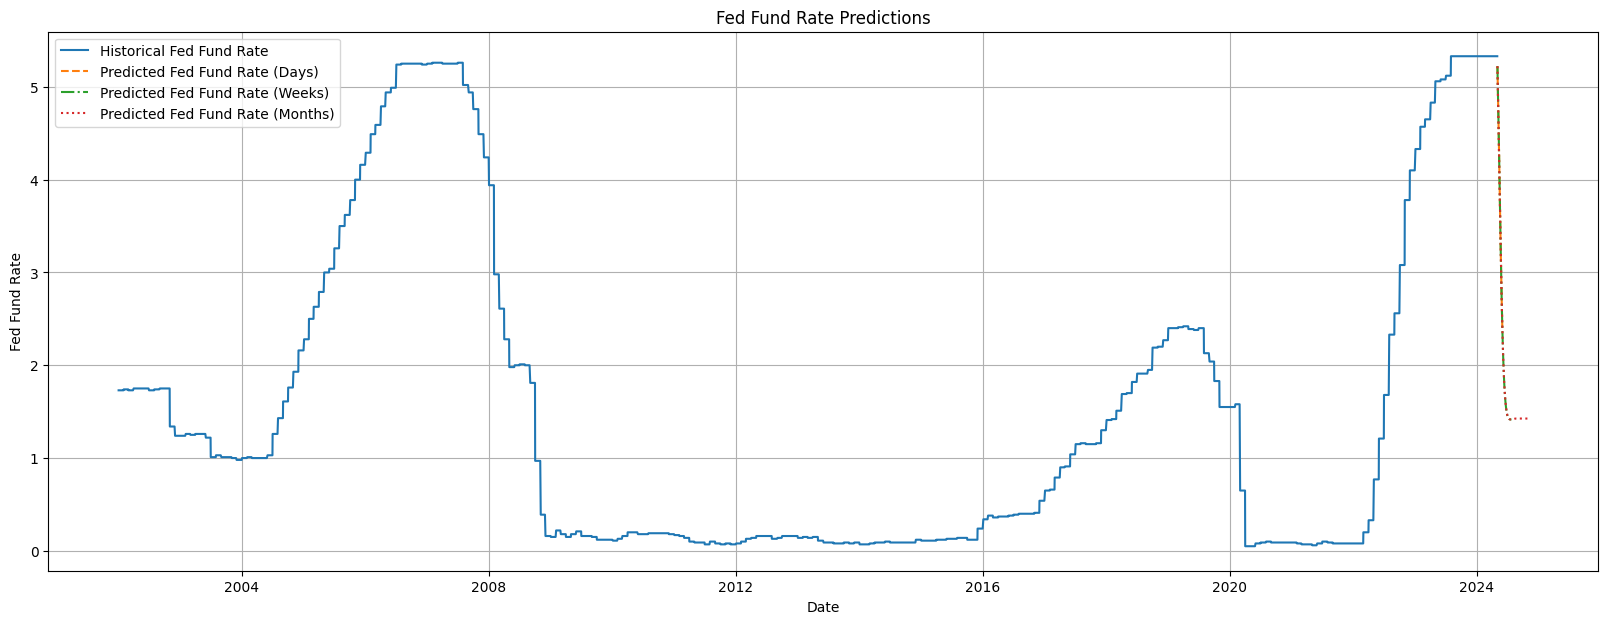

In [49]:
import matplotlib.pyplot as plt
# Plot the historical data and predictions using Matplotlib
plt.figure(figsize=(20, 7))

# Plot historical data
plt.plot(df.index, df['Fed_Fund_rate'], label='Historical Fed Fund Rate')

# Plot future predictions for days
plt.plot(future_days_df.index, future_days_df['Predicted_Fed_Fund_rate'], label='Predicted Fed Fund Rate (Days)', linestyle='--')

# Plot future predictions for weeks
plt.plot(future_weeks_df.index, future_weeks_df['Predicted_Fed_Fund_rate'], label='Predicted Fed Fund Rate (Weeks)', linestyle='-.')
 
# Plot future predictions for months
plt.plot(future_months_df.index, future_months_df['Predicted_Fed_Fund_rate'], label='Predicted Fed Fund Rate (Months)', linestyle=':')

# Customize the plot
plt.title('Fed Fund Rate Predictions')
plt.xlabel('Date')
plt.ylabel('Fed Fund Rate')
plt.legend()
plt.grid(True)
plt.show()
